<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Benchmark_Original_(MobileNetV3Large)_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [99]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn
import joblib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [5]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Wed Oct 29 14:38:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000Dataset.zip"
INDEX_SETTING = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [7]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "MobileNetV3LargeOriginal" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "FineTuning" # <= FineTuning หรือ FeatureExtraction
ROUND_NUM = 1 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

MODEL_CODE_NAME = "MobileNetV3Large"
TYPE_CODE_NAME = "Fine Tuning"

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [8]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [9]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000DatasetOversampling.zip -d /content/ham10000DatasetOversampling

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0031496_aug_1714.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0025661.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0029678_aug_1613.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0029301_aug_1952.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0025867_aug_2078.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0033200.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0028995_aug_395.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0028490_aug_480.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0031485_aug_1321.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0027392_aug_1725.jpg  
  inflating: /content/ham10000DatasetOversampling/train/bkl/ISIC_0032618_aug_724.jp

In [10]:
DATASET_DIR = "/content/ham10000DatasetOversampling"

## **Section 2: Preprocessing and augmentaion images**

### **Load dataset**

In [11]:
class TFDatasetPipeline:
    def __init__(self,
                 transform=None,
                 rescale=None,
                 preprocess_input=None):
        """
        Args:
            transform (albumentations.Compose, optional):
                Pipeline ของ Albumentations สำหรับ Augmentation
            preprocess_input (function, optional):
                ฟังก์ชัน Preprocessing ของโมเดล (เช่น resnet.preprocess_input)
                หากต้องการแค่ Rescale ให้ส่ง: 1./255
        """
        self.transform = transform
        self.rescale = rescale
        self.preprocess_input = preprocess_input
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.class_names = None

    def _build_class_names(self, df, y_cols, class_name_col, num_classes):
        if self.class_names is not None:
            return
        try:
            if class_name_col:
                mapping_df = df[[y_cols, class_name_col]].drop_duplicates().sort_values(by=y_cols)
                self.class_names = mapping_df[class_name_col].tolist()
                if len(self.class_names) != num_classes:
                    print(f"[Warning] Found {len(self.class_names)} class names but expected {num_classes}.")
            else:
                raise ValueError
        except Exception:
            print(f"[Warning] Could not extract class names. Using numeric labels instead.")
            self.class_names = [str(i) for i in range(num_classes)]

        print(f"Class indices: {dict(enumerate(self.class_names))}")

    def _transform_function(self, img_numpy):
        if self.transform is None:
            return img_numpy.astype(np.float32)
        raw_img = {"image": img_numpy}
        transformed = self.transform(**raw_img)
        return transformed["image"].astype(np.float32)

    @tf.function
    def _apply_transform(self, img_tensor, img_size):
        transformed = tf.numpy_function(
            func=self._transform_function,
            inp=[img_tensor],
            Tout=tf.float32
        )
        transformed.set_shape([*img_size, 3])
        return transformed

    def _load_and_resize(self, filepath, metadata, label, img_size):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, metadata, label

    def _process_image(self, img, is_training, img_size):
        if is_training and self.transform:
            img = self._apply_transform(img, img_size)

        if self.preprocess_input:
            img = self.preprocess_input(img)
        elif self.rescale:
            img = img * self.rescale

        return img

    def _process_label(self, label, num_classes, class_mode):
        label = tf.cast(label, tf.int32)
        if class_mode == "categorical":
            label = tf.one_hot(label, num_classes)
        elif class_mode != "sparse":
            raise ValueError(f"Unknown class_mode: {class_mode}")
        return label

    def _finalize_data(self, img, metadata, label,
                       num_classes, img_size, is_training, class_mode,
                       meta_shape):
        img = self._process_image(img, is_training, img_size)
        label = self._process_label(label, num_classes, class_mode)

        if meta_shape == 0:
            return img, label
        else:
            metadata = tf.cast(metadata, tf.float32)
            metadata.set_shape([meta_shape])
            return ((img, metadata), label)

    def flow_from_dataframe(
        self,
        df,
        X_cols,
        X_meta=None,
        y_cols=None,
        num_classes=None,
        class_name_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical",
        is_training=False,
        seed=42
    ):

        self._build_class_names(df, y_cols, class_name_col, num_classes)
        num_files = len(df)
        print(f"Found {num_files} files belonging to {num_classes} classes.")

        if X_meta is None:
            X_meta_data = [None] * num_files
            meta_shape = 0
        else:
            X_meta_data = X_meta.values
            meta_shape = X_meta_data.shape[1]
            print(f"[Info] Detected meta_shape={meta_shape} from input DataFrame.")

        dataset = tf.data.Dataset.from_tensor_slices(
            (df[X_cols].values, X_meta_data, df[y_cols].values)
        )

        dataset = dataset.map(
            lambda f, m, l: self._load_and_resize(f, m, l, target_size),
            num_parallel_calls=self.AUTOTUNE
        )
        dataset = dataset.cache()

        if is_training:
            dataset = dataset.shuffle(buffer_size=num_files, seed=seed, reshuffle_each_iteration=True)

        dataset = dataset.map(
            lambda img, m, l: self._finalize_data(
                img, m, l, num_classes, target_size,
                is_training, class_mode,
                meta_shape=meta_shape
            ),
            num_parallel_calls=self.AUTOTUNE
        )

        dataset = dataset.batch(batch_size).prefetch(self.AUTOTUNE)
        return dataset

In [12]:
df_train = pd.read_csv(f"{INDEX_SETTING}/metadata_train_new.csv")
df_val = pd.read_csv(f"{INDEX_SETTING}/metadata_val_new.csv")
df_test = pd.read_csv(f"{INDEX_SETTING}/metadata_test_new.csv")

transforms = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.2),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.15),
    A.RandomGamma(gamma_limit=(90, 110), p=0.2)
], seed=SEED)

In [61]:
def select_preprocess_input(model_name):
    if model_name == "ResNet50":
        preprocess_input = keras.applications.resnet50.preprocess_input
        decode_predictions = keras.applications.resnet50.decode_predictions
    elif model_name == "MobileNetV3Large" or model_name == "MobileNetV3Small":
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input
        decode_predictions = keras.applications.mobilenet_v3.decode_predictions
    else:
        preprocess_input = None,
        decode_predictions = None
    return preprocess_input, decode_predictions

In [62]:
preprocess_fn,decode_pred = select_preprocess_input(MODEL_CODE_NAME)
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 16
EPOCHS = 40

In [15]:
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
idx_to_class = {idx: name for idx, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)
print(f"Index to class: {idx_to_class}")
print(f"Number of classes: {NUM_CLASSES}")

Index to class: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Number of classes: 7


In [16]:
pipeline = TFDatasetPipeline(
    transform=transforms,
    rescale=None,
    preprocess_input=preprocess_fn
)

In [17]:
ds_train = pipeline.flow_from_dataframe(
    df=df_train,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=True,
    batch_size=BATCH_SIZE,
    seed=SEED
)

ds_val = pipeline.flow_from_dataframe(
    df=df_val,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

ds_test = pipeline.flow_from_dataframe(
    df=df_test,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 15626 files belonging to 7 classes.
Found 1979 files belonging to 7 classes.
Found 1956 files belonging to 7 classes.


## **Section 3: Preparing the model**

### **Define callback function**

In [19]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=5,
    mode="max",
    min_lr=1e-08,
    verbose=1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
) # Model checkpoint for save best model file

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=10,
    verbose=1,
    restore_best_weights=False
) # Early stopping

tensorboard = keras.callbacks.TensorBoard(
    log_dir=MODEL_TENSORBOARD_PATH,
    histogram_freq=1,
    write_graph=True,
    write_images=True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard, early_stopping]

### **Model parameters**

In [20]:
def build_model(input_shape, num_classes, model_name, trainable=False):
    image_input = keras.layers.Input(shape=input_shape, name="image_input")

    if model_name == "MobileNetV3Large":
        base_model = keras.applications.MobileNetV3Large(
            input_tensor=image_input,
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "ResNet50":
        base_model = keras.applications.ResNet50(
            input_tensor=image_input,
            include_top=False,
            weights="imagenet"
        )

    else:
        raise ValueError(f"Unknown model_name: {model_name}. Supported: ['MobileNetV3Large', 'ResNet50']")

    base_model.trainable = trainable

    image_features = keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    image_features = keras.layers.Dense(256, activation="relu", name="fc")(image_features)
    image_features = keras.layers.Dropout(0.3, name="dropout")(image_features)
    predictions = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(image_features)

    model = keras.models.Model(inputs=image_input, outputs=predictions)
    return model

In [21]:
model = build_model(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    model_name=MODEL_CODE_NAME,
    trainable=True
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [22]:
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-04,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name="Adam"
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.F1Score(name="f1_score", average="macro")
        ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,244,167 (12.38 MB)

 Trainable params: 3,219,767 (12.28 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **Section 4: Training the model**

In [23]:
training_start = time.time()

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4222 - f1_score: 0.3310 - loss: 1.4214 - precision: 0.6220 - recall: 0.2330
Epoch 1: val_accuracy improved from -inf to 0.66094, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3LargeOriginal_FineTuning_Adam_1/MobileNetV3LargeOriginal_best.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 183s 101ms/step - accuracy: 0.4223 - f1_score: 0.3311 - loss: 1.4212 - precision: 0.6221 - recall: 0.2331 - val_accuracy: 0.6609 - val_f1_score: 0.4093 - val_loss: 1.0020 - val_precision: 0.6954 - val_recall: 0.6276 - learning_rate: 1.0000e-04
Epoch 2/40
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6231 - f1_score: 0.6342 - loss: 0.9241 - precision: 0.8401 - recall: 0.5036
Epoch 2: val_accuracy improved from 0.66094 to 0.78474, saving model to /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3LargeOriginal_FineTuning_Adam_1/MobileNetV3LargeOriginal_best.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 92s 94ms/step - a

### **Save the model config**

In [24]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
#model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3LargeOriginal_FineTuning_Adam_1/MobileNetV3LargeOriginal_history.csv


Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3LargeOriginal_FineTuning_Adam_1/MobileNetV3LargeOriginal.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/MobileNetV3LargeOriginal_FineTuning_Adam_1/MobileNetV3LargeOriginal.h5


In [113]:
model = keras.models.load_model(MODEL_KERAS_PATH) # Load model

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmpblbetn1b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140103625948240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103450197264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103450193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103450192656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103625936336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103625947664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140099582262736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140099582261392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140103625947472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140099582259472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140099582260816

## **Section 5: Evaluation the model**

In [25]:
results = model.evaluate(ds_test, return_dict=True)

123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 635ms/step - accuracy: 0.7297 - f1_score: 0.5425 - loss: 1.7856 - precision: 0.7326 - recall: 0.7263


In [26]:
loss = results["loss"]
accuracy = results["accuracy"]
precision = results["precision"]
recall = results["recall"]
f1_score = results["f1_score"]

print(f"--Final Test Results--")
print(f"Loss      : {loss:.4f}")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1_score:.4f}")

--Final Test Results--
Loss      : 1.0868
Accuracy  : 0.8318
Precision : 0.8349
Recall    : 0.8298
F1 Score  : 0.7162


In [27]:
y_pred_prob = model.predict(ds_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in ds_test:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

123/123 ━━━━━━━━━━━━━━━━━━━━ 91s 728ms/step


In [30]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (1956,)
y_true shape: (1956,)
y_pred_onehot shape: (1956, 7)
y_true_onehot shape: (1956, 7)


### **Top-1 and Top-5 accuracy**

In [31]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8323
Top-1 Error: 0.1677
Top-5 Accuracy: 0.9959
Top-5 Error: 0.0041


### **Classification Report**

In [32]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

precision    recall  f1-score      support
akiec          0.622222  0.451613  0.523364    62.000000
bcc            0.793103  0.711340  0.750000    97.000000
bkl            0.746114  0.651584  0.695652   221.000000
df             0.782609  0.620690  0.692308    29.000000
mel            0.633333  0.518182  0.570000   220.000000
nv             0.879199  0.946882  0.911787  1299.000000
vasc           0.862069  0.892857  0.877193    28.000000
accuracy       0.832311  0.832311  0.832311     0.832311
macro avg      0.759807  0.684735  0.717186  1956.000000
weighted avg   0.822417  0.832311  0.824840  1956.000000

### **Training and Validation curve**

In [33]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    """
        สำหรับ Plot training and validation curve สำหรับ accuracy และ loss
        Args:
            history: ประวัติการ Train ที่ได้จาก model.fit()
            save_path: เซฟภาพเก็บไว้ที่ไหน (optional)
            fontsize: ขนาด font default 16
            title: สำหรับชื่อรูปภาพ (optional)
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

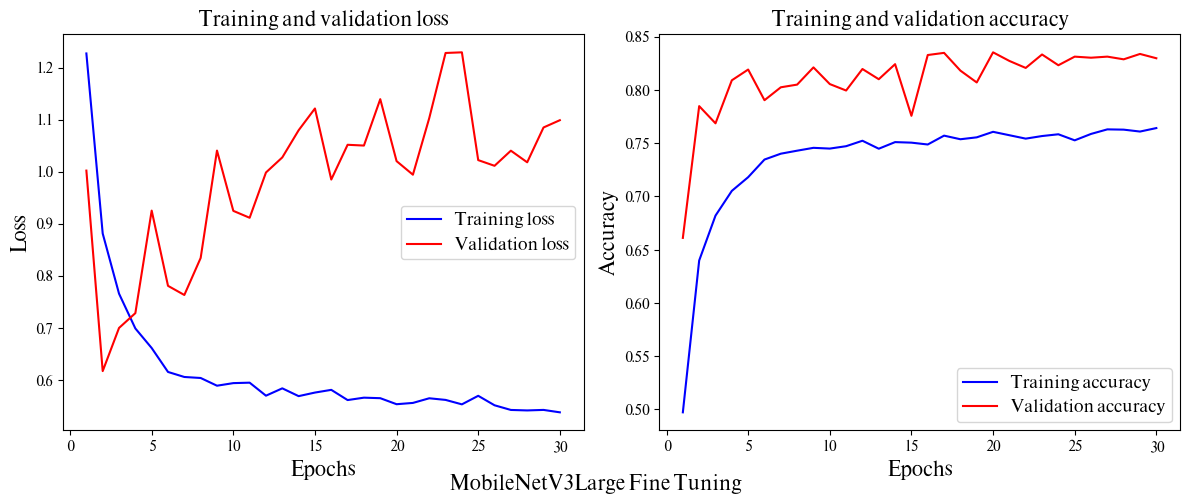

In [34]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}")

### **Confusion Matrix**

In [35]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    """
        สำหรับ Plot counfusion matrix
        Args:
            cm (array): ค่า confusion matrix ที่ต้องการ plot
            classes (list): รายชื่อคลาส (label names) สำหรับแกน X และ Y
            normalize (bool, default=False): ถ้า True จะทำ normalization ให้ค่าทุกแถวรวมเป็น 1
            title (str, optional): ชื่อกราฟที่จะแสดงด้านบน
            cmap (matplotlib colormap, default=plt.cm.Blues): โทนสีของ heatmap
            save_path (str, optional): โฟลเดอร์ที่จะบันทึกภาพ (ถ้าไม่กำหนดจะไม่บันทึก)
            fontsize (int, default=12): ขนาดตัวอักษรในกราฟ
    """
    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

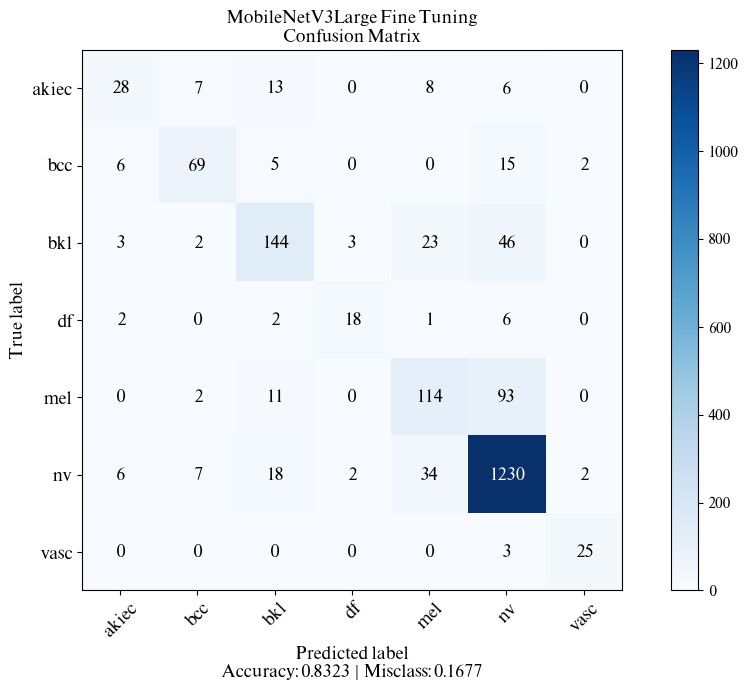

In [36]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

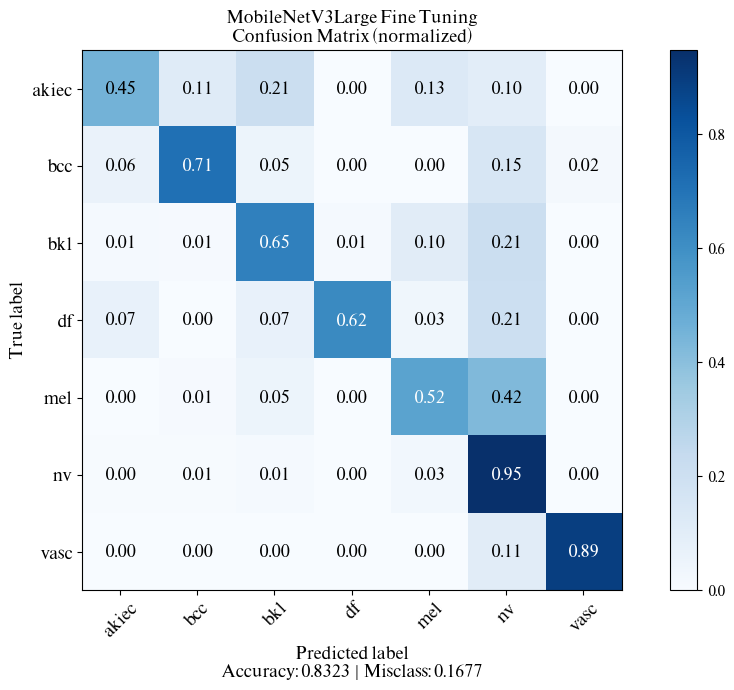

In [37]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [38]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    """
        y_true_onehot (ndarray): ค่า ground truth ในรูปแบบ one-hot encoded (ขนาด n_samples × n_classes)
        y_pred_prob (ndarray): ค่าความน่าจะเป็นที่โมเดลทำนาย (ขนาดเดียวกันกับ y_true_onehot)
        class_names (list): รายชื่อคลาสแต่ละคลาสที่ใช้แสดงในกราฟ
        title (str, optional): ชื่อกราฟ (ถ้าไม่ระบุจะใช้ชื่อเริ่มต้น “Receiver Operating Characteristic (ROC) - Multiclass”)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg)
        fontsize (int, default=14): ขนาดตัวอักษรในกราฟ
    """
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

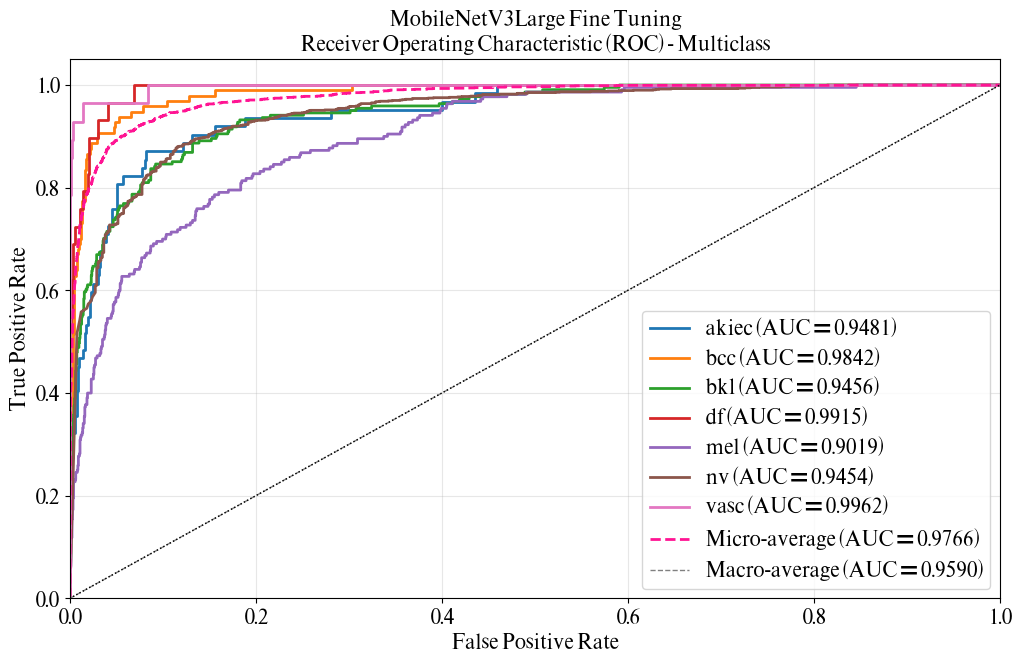

In [39]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", ASSETS_FOR_MODEL_PATH)

## **Section 6: XAI Explainable (AI)**

In [131]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def sample_one_per_class(df, label_col, n_classes=None, seed=42):
    """
    สุ่ม 1 ตัวอย่างต่อคลาสจาก DataFrame
    Args:
        df (pd.DataFrame): DataFrame เต็ม
        label_col (str): ชื่อ column ของ label
        n_classes (int, optional): จำนวนคลาสสูงสุดที่จะสุ่ม ถ้า None ใช้ทั้งหมด
        seed (int): random seed
    Returns:
        pd.DataFrame: DataFrame ของตัวอย่างที่สุ่มมา
    """
    sampled_df = df.groupby(label_col, group_keys=False)[df.columns].apply(
        lambda x: x.sample(1, random_state=seed)
    ).reset_index(drop=True)

    if n_classes is not None and len(sampled_df) > n_classes:
        sampled_df = sampled_df.sample(n=n_classes, random_state=seed)

    return sampled_df

In [157]:
test_sample_df = sample_one_per_class(df_test, label_col="cell_type_idx", n_classes=NUM_CLASSES, seed=SEED)
LAST_CONV_LAYER = "conv_1"

In [152]:
def plot_gradcam_for_classes(
    df_test, X_cols, y_cols, model, preprocess_fn,
    last_conv_layer_name, idx_to_class, n_classes=7,
    alpha=0.4, img_size=(224, 224), seed=42, fontsize=12,
    title=None, heatmap_only=False, save_path=None
):
    """
    สุ่มภาพจาก df_test ของแต่ละคลาส (ไม่ซ้ำ) แล้วทำ Grad-CAM และ plot 1 row x n_classes
    แสดงค่าความเชื่อมั่น พร้อมระบุสี title: เขียว=ถูก, แดง=ผิด
    ถ้า heatmap_only=True จะไม่ overlay กับภาพต้นฉบับ
    """
    sampled_df = sample_one_per_class(df_test, y_cols, n_classes=n_classes, seed=seed)

    fig, axes = plt.subplots(1, len(sampled_df), figsize=(4*len(sampled_df), 5))
    if len(sampled_df) == 1:
        axes = [axes]

    if title is not None:
        fig.suptitle(title, fontsize=fontsize + 2, y=1.05)

    for ax, (_, row) in zip(axes, sampled_df.iterrows()):
        img_path = row[X_cols]
        true_class_idx = row[y_cols]

        img_array = get_img_array(img_path, size=img_size)
        img_preprocessed = preprocess_fn(img_array)

        preds = model.predict(img_preprocessed, verbose=0)
        pred_index = np.argmax(preds[0])
        confidence = preds[0][pred_index]

        model.layers[-1].activation = None
        heatmap = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer_name, pred_index)

        # แปลง heatmap เป็นสี
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet = plt.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        # เลือก overlay หรือแค่ heatmap
        if heatmap_only:
            display_img = keras.utils.array_to_img(jet_heatmap)
        else:
            superimposed_img = jet_heatmap * alpha + img_array[0]  # batch dim = 0
            display_img = keras.utils.array_to_img(superimposed_img)

        true_class_name = idx_to_class[true_class_idx]
        pred_class_name = idx_to_class[pred_index]
        color = "green" if true_class_idx == pred_index else "red"

        ax.imshow(display_img)
        ax.axis("off")
        ax.set_title(
            f"True Label: {true_class_name}, Predict: {pred_class_name}\nConf: {confidence:.2f}",
            fontsize=fontsize, color=color
        )

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

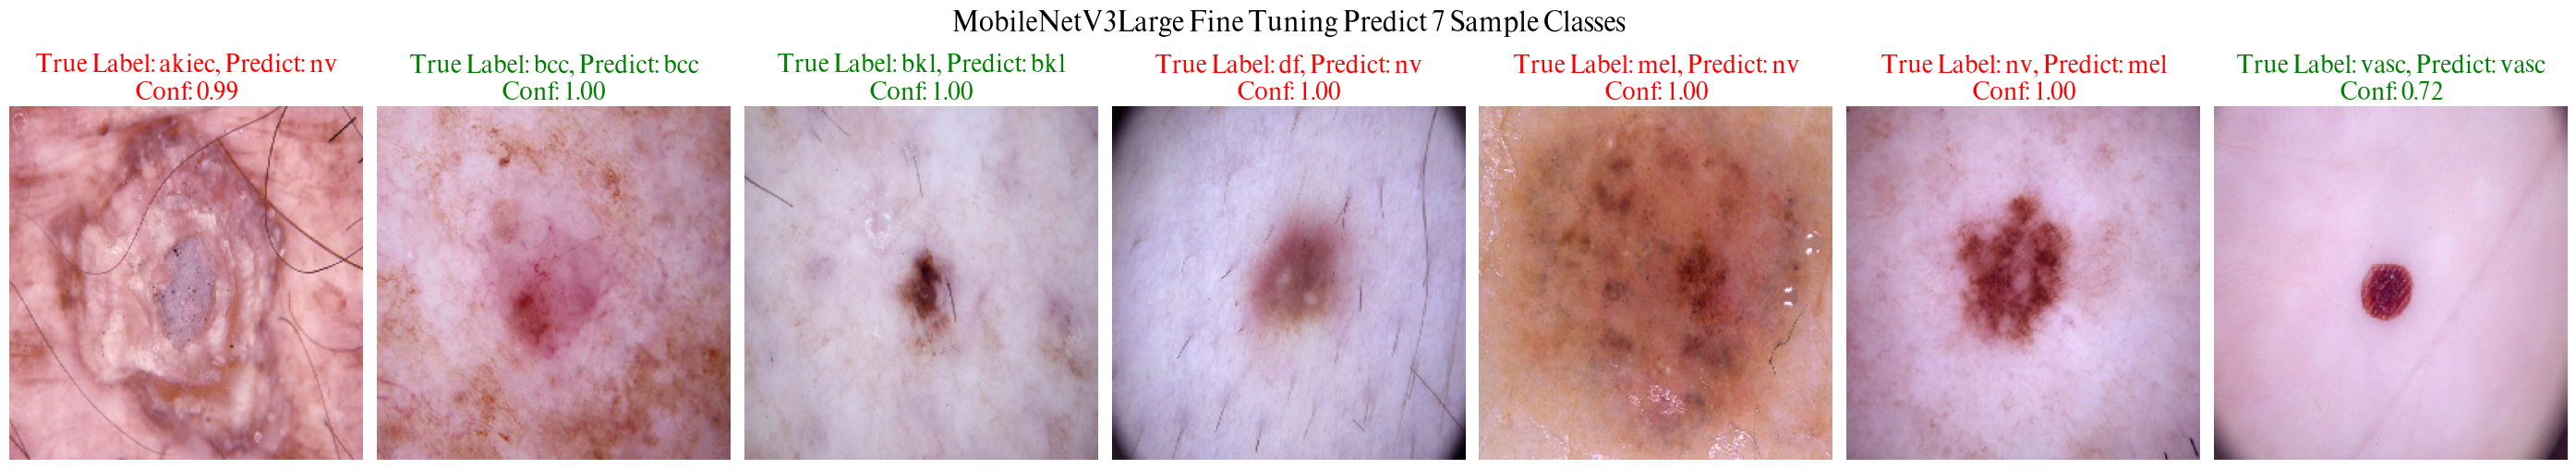

In [154]:
plot_gradcam_for_classes(
    df_test=test_sample_df,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    preprocess_fn=preprocess_fn,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=0,
    seed=SEED,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Predict 7 Sample Classes",
    heatmap_only=False,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/predict"
)

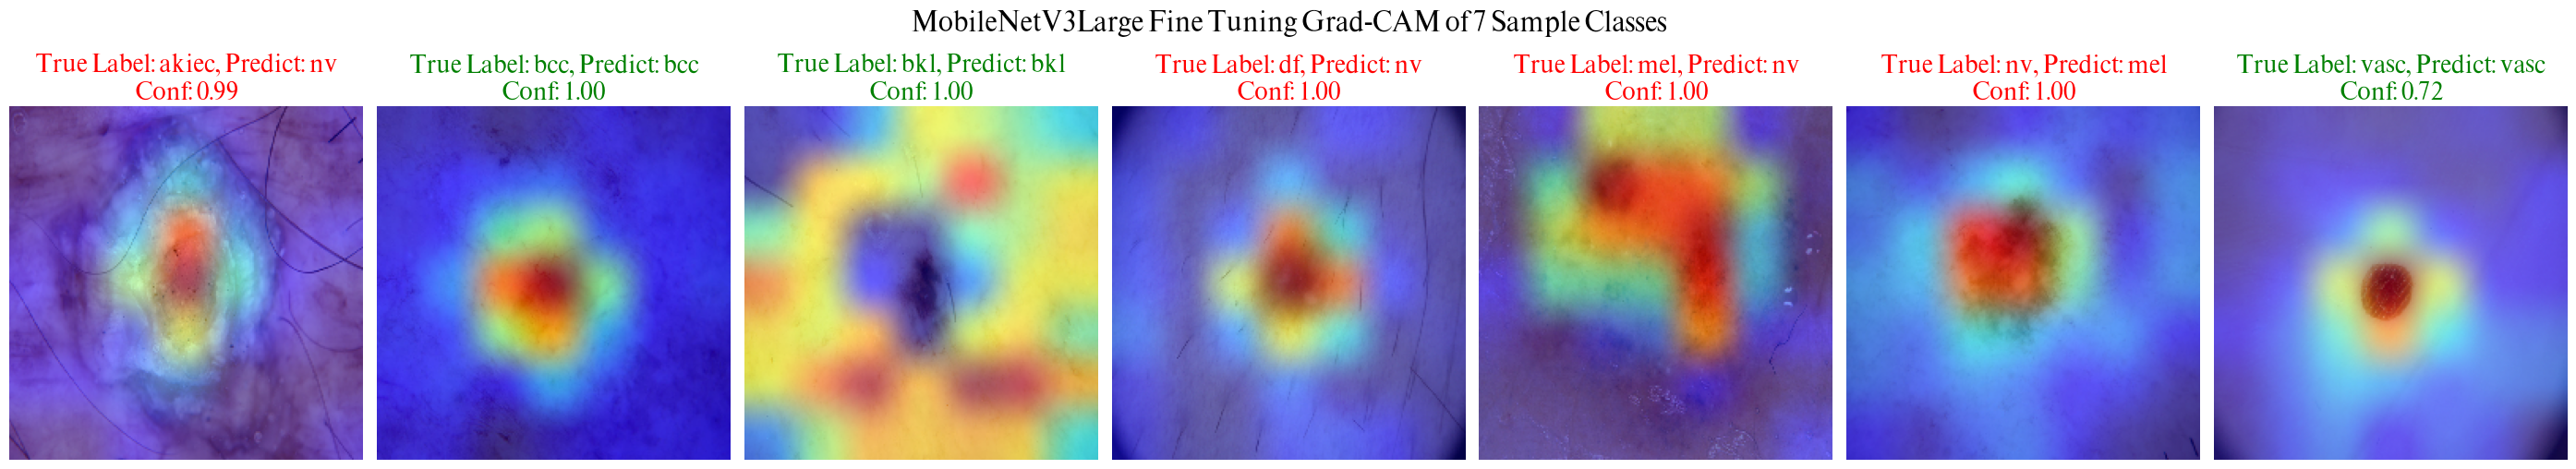

In [155]:
plot_gradcam_for_classes(
    df_test=test_sample_df,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    preprocess_fn=preprocess_fn,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=1.0,
    seed=SEED,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Grad-CAM of 7 Sample Classes",
    heatmap_only=False,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/grad_cam"
)

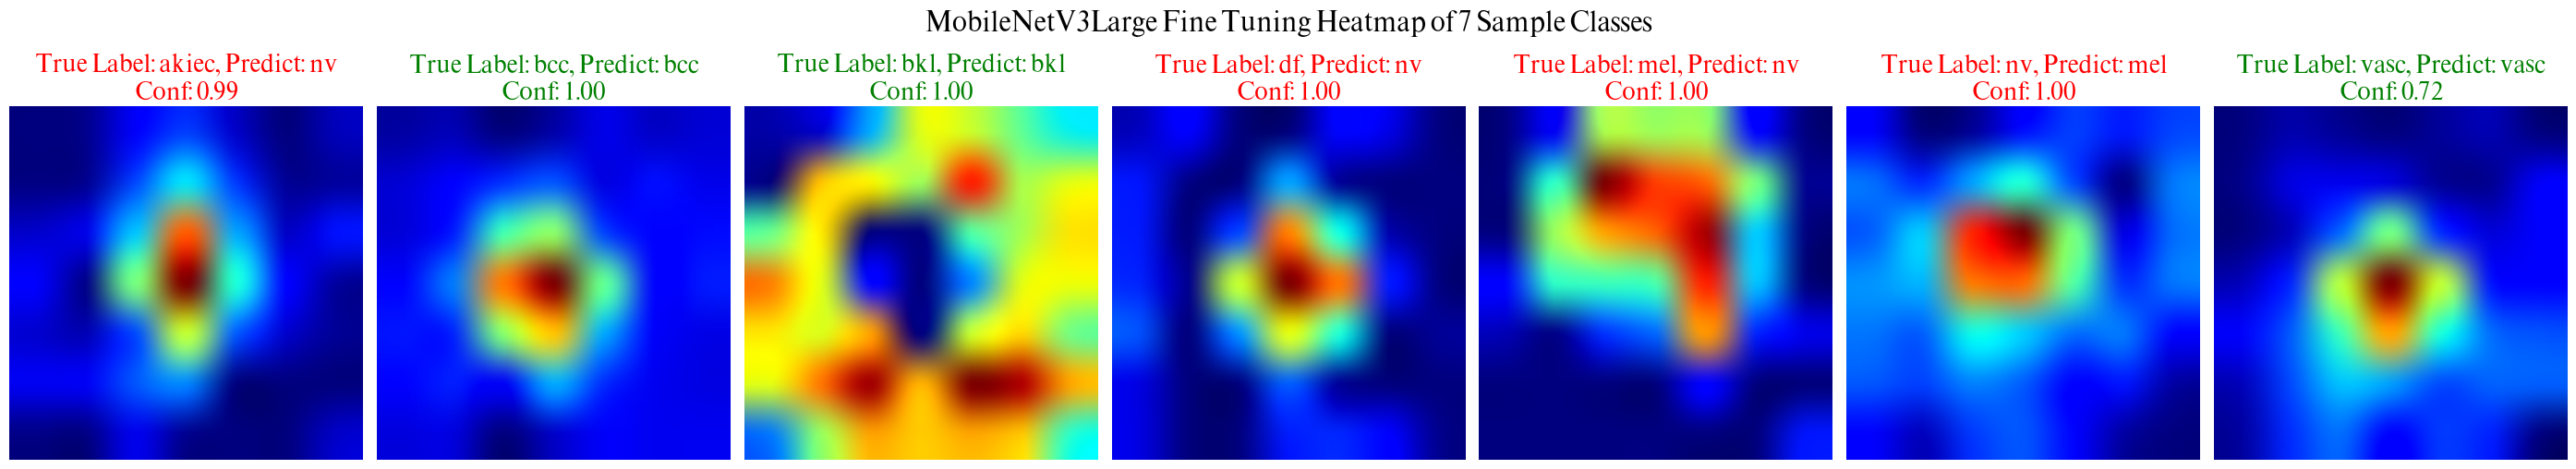

In [156]:
plot_gradcam_for_classes(
    df_test=test_sample_df,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    preprocess_fn=preprocess_fn,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=0,
    seed=SEED,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Heatmap of 7 Sample Classes",
    heatmap_only=True,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/heatmap"
)